In [94]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import feature_column
from sklearn.metrics import multilabel_confusion_matrix


from keras.models import Sequential
from keras.layers import Dense, Input
from pydoc import locate
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [59]:
table_features = []
table_labels = []
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
        table_features.append(value)
        print("{:20s}: {}".format(key,value.numpy()))
    for lab in label:
        table_labels.append(label)
        print(lab)

In [60]:
def df_to_dataset(dataframe, labels, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  #labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [61]:
def _preprocess_line(features, targets):
    # Pack the result into a dictionary
    features = dict(zip(visu_data.columns, features))
    #print(features)
    features.pop('sig_id')
    features.pop('cp_time')
    #targets.pop('sig_id')
    targets = tf.stack(targets[1:])
    return features, targets


In [63]:
for dirname, _, filenames in os.walk('Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Data\sample_submission.csv
Data\test_features.csv
Data\train_drug.csv
Data\train_features.csv
Data\train_targets_nonscored.csv
Data\train_targets_scored.csv


In [64]:
visu_data = pd.read_csv('./Data/train_features.csv')
visu_label = pd.read_csv('./Data/train_targets_scored.csv')
visu_data.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [70]:
X_train = pd.DataFrame(pd.read_csv('./Data/train_features.csv', nrows=5))
print(X_train.dtypes)
types = [str(), str(), str(), str()]
for i in range(4, len(X_train.dtypes)):
    if X_train.dtypes[i].kind == 'f':
        types.append(float())


sig_id      object
cp_type     object
cp_time      int64
cp_dose     object
g-0        float64
            ...   
c-95       float64
c-96       float64
c-97       float64
c-98       float64
c-99       float64
Length: 876, dtype: object


In [71]:
features = tf.data.experimental.CsvDataset('./Data/train_features.csv', record_defaults=types, header=True)

In [72]:
y = pd.DataFrame(pd.read_csv('./Data/train_targets_scored.csv', nrows=5))
types = ['']
for i in range(1, len(y.dtypes)):
    types.append(float())

In [73]:
targets = tf.data.experimental.CsvDataset('./Data/train_targets_scored.csv', record_defaults=types, header=True)

dataset = tf.data.Dataset.zip((features, targets))

In [74]:
dataset_size = dataset.reduce(np.int64(0), lambda x, _:x+1).numpy()
train_dataset = dataset.take(0.7*dataset_size)
val_dataset = dataset.skip(0.7*dataset_size)
val_dataset = dataset.take(dataset_size - 0.7*dataset_size)


In [75]:
train_dataset = train_dataset.map(_preprocess_line).batch(32)
val_dataset = val_dataset.map(_preprocess_line).batch(32)

In [76]:
all_columns = list(list(train_dataset.element_spec)[0].keys())
categorical_columns = [all_columns[0], all_columns[1]]
numerical_columns = all_columns[2:]
#numerical_columns.append(all_columns[1])


In [77]:
feature_columns = []

for col in categorical_columns:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(col, visu_data[col].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

In [78]:
for col in numerical_columns:
    feature_columns.append(feature_column.numeric_column(col))

In [79]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(2048, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(206)
])

In [80]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
history=model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=10)

Epoch 1/10
521/521 [==============================] - 124s 239ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 2/10
521/521 [==============================] - 131s 251ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0013 - val_accuracy: 0.9996
Epoch 3/10
521/521 [==============================] - 144s 276ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0015 - val_accuracy: 0.9996
Epoch 4/10
521/521 [==============================] - 146s 280ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 5/10
521/521 [==============================] - 148s 284ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 6/10
521/521 [==============================] - 144s 276ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0017 - val_accuracy: 0.9996
Epoch 7/10
521/521 [==============================] - 143s 274ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0011 -

In [103]:
show_batch(train_dataset)

cp_type             : [b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'ctl_vehicle' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp']
cp_dose             : [b'D1' b'D1' b'D1' b'D1' b'D2' b'D1' b'D2' b'D1' b'D1' b'D2' b'D2' b'D2'
 b'D1' b'D2' b'D1' b'D1' b'D1' b'D2' b'D2' b'D1' b'D2' b'D1' b'D1' b'D1'
 b'D2' b'D1' b'D1' b'D2' b'D1' b'D1' b'D1' b'D2']
g-0                 : [ 1.062e+00  7.430e-02  6.280e-01 -5.138e-01 -3.254e-01 -6.111e-01
  2.044e+00  2.711e-01 -3.014e-01 -6.300e-02 -2.875e-01 -3.864e-01
  3.000e-03 -6.884e-01  4.242e-01  6.670e-02  8.738e+00 -4.764e-01
 -4.694e-01 -1.428e-01 -2.924e-01 -1.119e-01  6.111e-01 -1.850e-02
  4.442e-01 -6.696e-01 -2.740e-01 -2.156e-01  1.088e-01  5.497e-01
 -7.220e-02 -2.149e-01]
g-1                 : [ 0.5577  0.4087  0.5817 -

 -0.6228 -0.4374  0.4981  0.0738 -0.5109]
g-334               : [-2.111e-01  4.150e-02  1.043e+00  2.451e-01 -6.595e-01  6.691e-01
  5.092e+00 -6.770e-01  2.371e-01  1.507e+00 -4.847e-01 -4.944e-01
 -2.829e-01 -9.169e-01  4.026e-01 -1.147e-01  7.993e+00 -5.469e-01
  3.620e-01 -1.713e-01  1.095e-01  2.100e-03 -1.505e-01  1.002e+00
 -1.091e+00  5.740e-01  7.000e-03 -7.444e-01 -2.970e-02 -4.455e-01
 -2.680e-01 -4.475e-01]
g-335               : [-0.0272  0.2605 -1.541   1.284   0.0814 -0.4431  3.662   2.999  -1.603
 -0.3361 -0.1637 -0.1305 -0.2618  0.2973  4.164  -0.3927  6.289  -0.3838
  0.621   0.1024  0.6495 -0.804  -0.145   0.3214 -1.41   -0.4356 -0.4143
 -0.0211 -0.6479 -1.142   0.6454  0.5646]
g-336               : [ 0.9574  0.488  -0.5556 -0.1404 -1.119  -1.179   3.732  -0.0399  0.6349
 -1.814  -0.2943 -0.3361  0.4782 -1.324  -1.403   0.2923  2.302  -2.194
  0.3851 -0.5463 -1.381   0.0742 -0.6359 -0.0086 -0.0654 -0.1635 -0.1548
  0.3502 -1.005   1.409   0.6316  0.1185]
g-337        

g-652               : [-0.2598 -0.6899  0.5315  1.67    0.4431  0.246   0.5892 -0.1639  0.5484
 -0.399  -0.2091 -0.1075  0.1497  0.519   0.4543 -0.2648 -4.12   -0.5514
 -0.6175 -1.089  -0.4786  0.2639  0.5491  1.156   0.023   0.134  -1.656
  0.036   0.6431  1.2     0.6206 -0.3507]
g-653               : [ 8.483e-01  9.500e-03  7.145e-01  1.614e+00  1.485e+00 -7.914e-01
 -4.427e-01 -3.084e-01  1.470e-02 -2.045e-01  4.917e-01 -1.263e+00
  2.762e-01  1.984e+00 -9.830e-01 -1.100e-01 -2.425e+00  2.350e-01
 -1.282e-01 -1.335e-01 -1.752e-01  1.461e-01  2.888e-01 -1.090e-02
  4.339e-01  4.345e-01  9.123e-01  3.687e-01 -2.930e-02  4.791e-01
 -1.700e-03  6.545e-01]
g-654               : [ 0.6825 -0.2209  0.3622 -0.0307 -0.0666 -0.2853 -4.637  -0.6584  0.1655
 -0.2259 -0.1388  1.057   0.4045 -1.907   1.325  -0.3613  0.2343 -1.04
  0.5644 -0.3714 -0.7413  0.313   1.      1.022  -1.684  -0.5834 -1.162
  1.442  -0.5103  0.7038 -0.0386  1.843 ]
g-655               : [ 0.4016 -0.4061  0.0651  0.1174  0

In [104]:
labels_val = visu_label[int(0.7*dataset_size)+1::]
labels_val = labels_val.drop(['sig_id'], axis=1)
result_prediction = model.predict(val_dataset)

In [99]:
bool_res = []
for row in result_prediction:
    for col in row:
        bool_res.append(col == max(row))

print(sum(multilabel_confusion_matrix((labels_val > 0), np.asarray(bool_res).reshape(206, 7144))))

ValueError: Found input variables with inconsistent numbers of samples: [7144, 206]

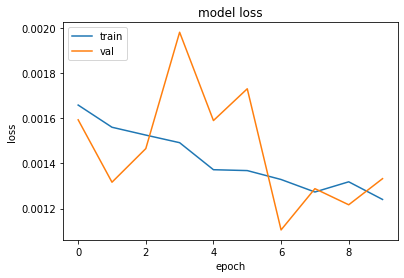

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

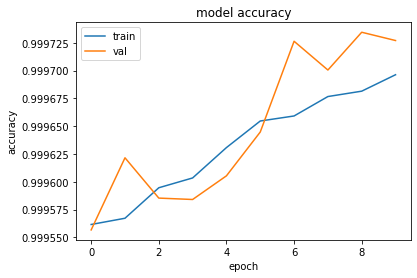

In [107]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()